# 6. Wasserstein GAN on MNIST with FC layers

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (05/04/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch import Tensor
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

In [3]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root = './data/',
                                   train = True,
                                   transform = transform,
                                   download = True)

In [5]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Critic model as a set of FC layers

In [6]:
# Discriminator
class Dicriminator(nn.Module):
    
    def __init__(self, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.D = nn.Sequential(nn.Linear(image_size, hidden_size),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_size, 1),
                               nn.Sigmoid())
        
    def forward(self, x):
        return self.D(x)

In [7]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.D = nn.Sequential(nn.Linear(image_size, hidden_size),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        return self.D(x)

### Generator model as a set of FC layers

In [8]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.G = nn.Sequential(nn.Linear(latent_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, image_size),
                               nn.Tanh())
        
    def forward(self, x):
        return self.G(x)

### Trainer function

In [9]:
# Hyperparameters for model generation and training
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 300
batch_size = 32
lambda_val = 0 #0.01
n_critic = 5
n_generator = 1

In [10]:
# Create discriminator model
f = Critic(hidden_size, image_size)
f.to(device)

Critic(
  (D): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [11]:
# Create generator model
G = Generator(latent_size, hidden_size, image_size)
G.to(device)

Generator(
  (G): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
)

In [12]:
# Losses and optimizers
d_optimizer = torch.optim.Adam(f.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [13]:
# History trackers for training curves
# Keeping track of losses
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

**Note: running the cell below (our trainer function) will take a long time!**

In [14]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        # 1. Flatten image
        images = images.view(batch_size, -1).to(device)
        images = Variable(images, requires_grad = True)
        
        
        """
        PART 1: TRAIN THE CRITIC
        """

        # 2. Compute mean of critic decisions using real images
        outputs_real = f(images)
        
        # 2.bis. Compute mean of critic decisions using fake images
        z = torch.randn(batch_size, latent_size).to(device)
        z = Variable(z)
        fake_images = G(z)
        outputs_fake = f(fake_images)
        
        # 3. Compute gradient regularization
        real_grad_out = Variable(Tensor(images.size(0), 1).fill_(1.0), requires_grad = False).to(device)
        real_grad = autograd.grad(outputs_real, images, real_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1)**3
        fake_grad_out = Variable(Tensor(fake_images.size(0), 1).fill_(1.0), requires_grad = False).to(device)
        fake_grad = autograd.grad(outputs_fake, fake_images, fake_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1)**3
        reg_term = torch.mean(real_grad_norm + fake_grad_norm)
        
        # 4. Backprop and optimize for f
        # Loss is simply the difference between means, plus regularization term
        # Remember to reset gradients for both optimizers!
        d_loss = -torch.mean(outputs_real) + torch.mean(outputs_fake) + reg_term
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 4.bis. Optional, weight clipping on critic
        # (Mentioned in WGAN paper)
        for p in f.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        
        """
        PART 2: TRAIN THE GENERATOR
        """

        # 5. Generate fresh noise samples and produce fake images
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = f(fake_images)
        
        # 6. Loss for G
        g_loss = - torch.mean(outputs)
        
        # 7. Backprop and optimize G
        # Remember to reset gradients for both optimizers!
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
        """
        PART 3: UPDATE STATISTICS FOR VISUALIZATION LATER
        """
        
        # 8. Update the losses and scores for mini-batches
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
            + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
            + g_loss.item()*(1./(i+1.))
        
        # 9. Display
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))

Epoch [0/300], Step [200/1875], d_loss: 0.2480, g_loss: -0.5578
Epoch [0/300], Step [400/1875], d_loss: -0.3291, g_loss: 0.2361
Epoch [0/300], Step [600/1875], d_loss: 0.0516, g_loss: 0.3762
Epoch [0/300], Step [800/1875], d_loss: -0.0299, g_loss: 0.1022
Epoch [0/300], Step [1000/1875], d_loss: -0.1928, g_loss: -0.1463
Epoch [0/300], Step [1200/1875], d_loss: -0.5706, g_loss: 0.4576
Epoch [0/300], Step [1400/1875], d_loss: -0.0829, g_loss: 0.1535
Epoch [0/300], Step [1600/1875], d_loss: -0.0340, g_loss: -0.0305
Epoch [0/300], Step [1800/1875], d_loss: 0.0039, g_loss: -0.0556
Epoch [1/300], Step [200/1875], d_loss: 0.0132, g_loss: 0.0157
Epoch [1/300], Step [400/1875], d_loss: 0.1563, g_loss: -0.6379
Epoch [1/300], Step [600/1875], d_loss: -0.2212, g_loss: -0.3267
Epoch [1/300], Step [800/1875], d_loss: -0.4175, g_loss: -0.2164
Epoch [1/300], Step [1000/1875], d_loss: 0.2079, g_loss: 0.8056
Epoch [1/300], Step [1200/1875], d_loss: -0.0496, g_loss: -0.0304
Epoch [1/300], Step [1400/1875]

Epoch [14/300], Step [200/1875], d_loss: -0.0376, g_loss: 0.0013
Epoch [14/300], Step [400/1875], d_loss: -0.0364, g_loss: 0.0973
Epoch [14/300], Step [600/1875], d_loss: -0.0266, g_loss: -0.1739
Epoch [14/300], Step [800/1875], d_loss: 0.0450, g_loss: -0.0377
Epoch [14/300], Step [1000/1875], d_loss: -0.0114, g_loss: 0.1143
Epoch [14/300], Step [1200/1875], d_loss: -0.0513, g_loss: -0.1968
Epoch [14/300], Step [1400/1875], d_loss: -0.0204, g_loss: 0.0850
Epoch [14/300], Step [1600/1875], d_loss: -0.1855, g_loss: 0.2613
Epoch [14/300], Step [1800/1875], d_loss: -0.0861, g_loss: -0.1845
Epoch [15/300], Step [200/1875], d_loss: -0.0911, g_loss: 0.0485
Epoch [15/300], Step [400/1875], d_loss: -0.0031, g_loss: 0.0236
Epoch [15/300], Step [600/1875], d_loss: -0.0279, g_loss: 0.0110
Epoch [15/300], Step [800/1875], d_loss: -0.0610, g_loss: -0.0237
Epoch [15/300], Step [1000/1875], d_loss: -0.0557, g_loss: -0.0054
Epoch [15/300], Step [1200/1875], d_loss: -0.0713, g_loss: -0.0181
Epoch [15/30

Epoch [27/300], Step [1800/1875], d_loss: -0.0161, g_loss: -0.0035
Epoch [28/300], Step [200/1875], d_loss: -0.0137, g_loss: -0.1327
Epoch [28/300], Step [400/1875], d_loss: -0.0205, g_loss: 0.1408
Epoch [28/300], Step [600/1875], d_loss: 0.0235, g_loss: -0.1545
Epoch [28/300], Step [800/1875], d_loss: -0.0707, g_loss: -0.1033
Epoch [28/300], Step [1000/1875], d_loss: 0.0363, g_loss: 0.0331
Epoch [28/300], Step [1200/1875], d_loss: -0.0487, g_loss: 0.4407
Epoch [28/300], Step [1400/1875], d_loss: -0.0723, g_loss: 0.3963
Epoch [28/300], Step [1600/1875], d_loss: 0.0979, g_loss: -0.5155
Epoch [28/300], Step [1800/1875], d_loss: -0.1257, g_loss: -0.6772
Epoch [29/300], Step [200/1875], d_loss: 0.0009, g_loss: -0.7256
Epoch [29/300], Step [400/1875], d_loss: -0.0636, g_loss: -0.1146
Epoch [29/300], Step [600/1875], d_loss: 0.0005, g_loss: 0.8335
Epoch [29/300], Step [800/1875], d_loss: -0.0039, g_loss: -0.2202
Epoch [29/300], Step [1000/1875], d_loss: -0.0028, g_loss: 0.0111
Epoch [29/300]

Epoch [41/300], Step [1600/1875], d_loss: -0.0851, g_loss: -0.1278
Epoch [41/300], Step [1800/1875], d_loss: -0.0315, g_loss: 0.5999
Epoch [42/300], Step [200/1875], d_loss: 0.0985, g_loss: 0.6036
Epoch [42/300], Step [400/1875], d_loss: 0.0059, g_loss: -0.0151
Epoch [42/300], Step [600/1875], d_loss: -0.1546, g_loss: -0.5204
Epoch [42/300], Step [800/1875], d_loss: 0.1185, g_loss: 0.2139
Epoch [42/300], Step [1000/1875], d_loss: -0.0658, g_loss: 0.1825
Epoch [42/300], Step [1200/1875], d_loss: -0.1080, g_loss: -0.6830
Epoch [42/300], Step [1400/1875], d_loss: 0.1974, g_loss: 0.4327
Epoch [42/300], Step [1600/1875], d_loss: -0.0879, g_loss: 0.2345
Epoch [42/300], Step [1800/1875], d_loss: -0.3958, g_loss: -0.5521
Epoch [43/300], Step [200/1875], d_loss: -0.0455, g_loss: -0.1170
Epoch [43/300], Step [400/1875], d_loss: -0.1736, g_loss: 0.4615
Epoch [43/300], Step [600/1875], d_loss: -0.1637, g_loss: -0.6451
Epoch [43/300], Step [800/1875], d_loss: 0.0992, g_loss: 0.4300
Epoch [43/300], 

Epoch [55/300], Step [1400/1875], d_loss: -0.0496, g_loss: 0.0525
Epoch [55/300], Step [1600/1875], d_loss: -0.0338, g_loss: -0.0006
Epoch [55/300], Step [1800/1875], d_loss: -0.0372, g_loss: 0.0469
Epoch [56/300], Step [200/1875], d_loss: 0.0101, g_loss: 0.0453
Epoch [56/300], Step [400/1875], d_loss: -0.0865, g_loss: 0.0681
Epoch [56/300], Step [600/1875], d_loss: -0.0782, g_loss: -0.0333
Epoch [56/300], Step [800/1875], d_loss: -0.0401, g_loss: -0.0186
Epoch [56/300], Step [1000/1875], d_loss: 0.0031, g_loss: 0.1390
Epoch [56/300], Step [1200/1875], d_loss: -0.0702, g_loss: -0.0736
Epoch [56/300], Step [1400/1875], d_loss: -0.0493, g_loss: -0.1312
Epoch [56/300], Step [1600/1875], d_loss: -0.0774, g_loss: 0.1367
Epoch [56/300], Step [1800/1875], d_loss: -0.0133, g_loss: -0.0697
Epoch [57/300], Step [200/1875], d_loss: -0.0363, g_loss: 0.0475
Epoch [57/300], Step [400/1875], d_loss: -0.0709, g_loss: -0.0325
Epoch [57/300], Step [600/1875], d_loss: -0.0685, g_loss: 0.0786
Epoch [57/30

Epoch [69/300], Step [1200/1875], d_loss: -0.0601, g_loss: 0.1457
Epoch [69/300], Step [1400/1875], d_loss: -0.0347, g_loss: -0.1007
Epoch [69/300], Step [1600/1875], d_loss: -0.0054, g_loss: 0.0338
Epoch [69/300], Step [1800/1875], d_loss: -0.0530, g_loss: -0.0563
Epoch [70/300], Step [200/1875], d_loss: -0.0862, g_loss: 0.0543
Epoch [70/300], Step [400/1875], d_loss: -0.0654, g_loss: 0.0075
Epoch [70/300], Step [600/1875], d_loss: -0.0467, g_loss: -0.0134
Epoch [70/300], Step [800/1875], d_loss: -0.1186, g_loss: -0.0536
Epoch [70/300], Step [1000/1875], d_loss: -0.0778, g_loss: 0.0925
Epoch [70/300], Step [1200/1875], d_loss: 0.0433, g_loss: -0.1432
Epoch [70/300], Step [1400/1875], d_loss: 0.0859, g_loss: -0.0704
Epoch [70/300], Step [1600/1875], d_loss: -0.0073, g_loss: 0.0595
Epoch [70/300], Step [1800/1875], d_loss: -0.1015, g_loss: 0.1430
Epoch [71/300], Step [200/1875], d_loss: -0.1135, g_loss: 0.1264
Epoch [71/300], Step [400/1875], d_loss: 0.0578, g_loss: -0.1171
Epoch [71/30

Epoch [83/300], Step [1000/1875], d_loss: -0.0176, g_loss: -0.0225
Epoch [83/300], Step [1200/1875], d_loss: -0.0135, g_loss: -0.0360
Epoch [83/300], Step [1400/1875], d_loss: -0.0245, g_loss: -0.0047
Epoch [83/300], Step [1600/1875], d_loss: -0.0271, g_loss: 0.0156
Epoch [83/300], Step [1800/1875], d_loss: -0.0182, g_loss: -0.0130
Epoch [84/300], Step [200/1875], d_loss: 0.0065, g_loss: -0.0018
Epoch [84/300], Step [400/1875], d_loss: -0.0234, g_loss: 0.0889
Epoch [84/300], Step [600/1875], d_loss: -0.0432, g_loss: -0.0010
Epoch [84/300], Step [800/1875], d_loss: -0.0541, g_loss: 0.0008
Epoch [84/300], Step [1000/1875], d_loss: 0.0128, g_loss: 0.0351
Epoch [84/300], Step [1200/1875], d_loss: -0.0276, g_loss: -0.0542
Epoch [84/300], Step [1400/1875], d_loss: -0.0420, g_loss: 0.0059
Epoch [84/300], Step [1600/1875], d_loss: -0.0345, g_loss: 0.0380
Epoch [84/300], Step [1800/1875], d_loss: -0.0221, g_loss: -0.0114
Epoch [85/300], Step [200/1875], d_loss: -0.0870, g_loss: -0.0183
Epoch [8

Epoch [97/300], Step [800/1875], d_loss: -0.0575, g_loss: 0.0268
Epoch [97/300], Step [1000/1875], d_loss: -0.0901, g_loss: 0.0194
Epoch [97/300], Step [1200/1875], d_loss: -0.0646, g_loss: -0.0311
Epoch [97/300], Step [1400/1875], d_loss: -0.0853, g_loss: -0.0783
Epoch [97/300], Step [1600/1875], d_loss: -0.0747, g_loss: 0.1442
Epoch [97/300], Step [1800/1875], d_loss: -0.0158, g_loss: -0.2054
Epoch [98/300], Step [200/1875], d_loss: -0.0200, g_loss: -0.0507
Epoch [98/300], Step [400/1875], d_loss: -0.0330, g_loss: 0.0578
Epoch [98/300], Step [600/1875], d_loss: -0.0483, g_loss: -0.0477
Epoch [98/300], Step [800/1875], d_loss: -0.0477, g_loss: -0.1173
Epoch [98/300], Step [1000/1875], d_loss: -0.0200, g_loss: 0.0010
Epoch [98/300], Step [1200/1875], d_loss: -0.0734, g_loss: -0.1000
Epoch [98/300], Step [1400/1875], d_loss: 0.0039, g_loss: 0.0098
Epoch [98/300], Step [1600/1875], d_loss: -0.0602, g_loss: 0.2958
Epoch [98/300], Step [1800/1875], d_loss: -0.1335, g_loss: 0.3949
Epoch [99

Epoch [111/300], Step [200/1875], d_loss: -0.0682, g_loss: 0.0614
Epoch [111/300], Step [400/1875], d_loss: 0.0030, g_loss: 0.0444
Epoch [111/300], Step [600/1875], d_loss: -0.0355, g_loss: -0.1205
Epoch [111/300], Step [800/1875], d_loss: -0.0860, g_loss: -0.0301
Epoch [111/300], Step [1000/1875], d_loss: -0.0584, g_loss: 0.0515
Epoch [111/300], Step [1200/1875], d_loss: -0.0377, g_loss: -0.1768
Epoch [111/300], Step [1400/1875], d_loss: 0.0290, g_loss: 0.0292
Epoch [111/300], Step [1600/1875], d_loss: -0.0107, g_loss: -0.0085
Epoch [111/300], Step [1800/1875], d_loss: -0.0290, g_loss: 0.1144
Epoch [112/300], Step [200/1875], d_loss: -0.0668, g_loss: -0.0045
Epoch [112/300], Step [400/1875], d_loss: -0.0220, g_loss: 0.0150
Epoch [112/300], Step [600/1875], d_loss: -0.0150, g_loss: -0.1410
Epoch [112/300], Step [800/1875], d_loss: -0.0541, g_loss: 0.1140
Epoch [112/300], Step [1000/1875], d_loss: -0.0248, g_loss: -0.1065
Epoch [112/300], Step [1200/1875], d_loss: -0.0462, g_loss: 0.124

Epoch [124/300], Step [1400/1875], d_loss: -0.0077, g_loss: 0.0317
Epoch [124/300], Step [1600/1875], d_loss: -0.1124, g_loss: 0.0435
Epoch [124/300], Step [1800/1875], d_loss: 0.0168, g_loss: -0.0082
Epoch [125/300], Step [200/1875], d_loss: -0.0220, g_loss: 0.0080
Epoch [125/300], Step [400/1875], d_loss: -0.0195, g_loss: 0.0348
Epoch [125/300], Step [600/1875], d_loss: -0.0417, g_loss: -0.1070
Epoch [125/300], Step [800/1875], d_loss: -0.0669, g_loss: 0.0964
Epoch [125/300], Step [1000/1875], d_loss: 0.0701, g_loss: -0.0815
Epoch [125/300], Step [1200/1875], d_loss: -0.0358, g_loss: 0.0836
Epoch [125/300], Step [1400/1875], d_loss: -0.1300, g_loss: 0.0466
Epoch [125/300], Step [1600/1875], d_loss: 0.0854, g_loss: -0.1378
Epoch [125/300], Step [1800/1875], d_loss: -0.0801, g_loss: 0.0641
Epoch [126/300], Step [200/1875], d_loss: -0.0456, g_loss: -0.1038
Epoch [126/300], Step [400/1875], d_loss: -0.0932, g_loss: 0.2440
Epoch [126/300], Step [600/1875], d_loss: -0.0262, g_loss: -0.0691

Epoch [138/300], Step [800/1875], d_loss: 0.0265, g_loss: -0.0195
Epoch [138/300], Step [1000/1875], d_loss: -0.0311, g_loss: 0.0092
Epoch [138/300], Step [1200/1875], d_loss: -0.0265, g_loss: -0.1592
Epoch [138/300], Step [1400/1875], d_loss: -0.0704, g_loss: 0.0691
Epoch [138/300], Step [1600/1875], d_loss: 0.0061, g_loss: -0.1017
Epoch [138/300], Step [1800/1875], d_loss: -0.1545, g_loss: 0.1878
Epoch [139/300], Step [200/1875], d_loss: -0.1427, g_loss: 0.0856
Epoch [139/300], Step [400/1875], d_loss: 0.0881, g_loss: 0.0582
Epoch [139/300], Step [600/1875], d_loss: -0.1430, g_loss: 0.3451
Epoch [139/300], Step [800/1875], d_loss: 0.0786, g_loss: -0.2921
Epoch [139/300], Step [1000/1875], d_loss: -0.0212, g_loss: -0.0212
Epoch [139/300], Step [1200/1875], d_loss: -0.0987, g_loss: 0.5308
Epoch [139/300], Step [1400/1875], d_loss: 0.1434, g_loss: -0.4874
Epoch [139/300], Step [1600/1875], d_loss: 0.0327, g_loss: 0.0739
Epoch [139/300], Step [1800/1875], d_loss: 0.0125, g_loss: -0.1220


Epoch [152/300], Step [200/1875], d_loss: -0.1529, g_loss: -0.1212
Epoch [152/300], Step [400/1875], d_loss: -0.3064, g_loss: 0.8692
Epoch [152/300], Step [600/1875], d_loss: -0.0460, g_loss: -0.9649
Epoch [152/300], Step [800/1875], d_loss: 0.0544, g_loss: 0.2822
Epoch [152/300], Step [1000/1875], d_loss: 0.0295, g_loss: -0.0580
Epoch [152/300], Step [1200/1875], d_loss: -0.0412, g_loss: -0.2082
Epoch [152/300], Step [1400/1875], d_loss: -0.1087, g_loss: 0.3769
Epoch [152/300], Step [1600/1875], d_loss: -0.1486, g_loss: -0.5603
Epoch [152/300], Step [1800/1875], d_loss: -0.1839, g_loss: 0.2704
Epoch [153/300], Step [200/1875], d_loss: -0.1357, g_loss: -1.0188
Epoch [153/300], Step [400/1875], d_loss: -0.1073, g_loss: 0.8443
Epoch [153/300], Step [600/1875], d_loss: 0.0955, g_loss: -0.7573
Epoch [153/300], Step [800/1875], d_loss: -0.1614, g_loss: 0.9728
Epoch [153/300], Step [1000/1875], d_loss: -0.1075, g_loss: -0.8607
Epoch [153/300], Step [1200/1875], d_loss: 0.1045, g_loss: 0.3811

Epoch [165/300], Step [1400/1875], d_loss: 0.0342, g_loss: -0.0510
Epoch [165/300], Step [1600/1875], d_loss: -0.0381, g_loss: -0.0117
Epoch [165/300], Step [1800/1875], d_loss: 0.0155, g_loss: -0.0619
Epoch [166/300], Step [200/1875], d_loss: -0.1456, g_loss: 0.0202
Epoch [166/300], Step [400/1875], d_loss: 0.0174, g_loss: -0.0487
Epoch [166/300], Step [600/1875], d_loss: -0.1303, g_loss: 0.2908
Epoch [166/300], Step [800/1875], d_loss: -0.0860, g_loss: -0.2714
Epoch [166/300], Step [1000/1875], d_loss: 0.0180, g_loss: 0.0858
Epoch [166/300], Step [1200/1875], d_loss: -0.0290, g_loss: -0.0125
Epoch [166/300], Step [1400/1875], d_loss: -0.0140, g_loss: 0.0426
Epoch [166/300], Step [1600/1875], d_loss: -0.0134, g_loss: -0.0666
Epoch [166/300], Step [1800/1875], d_loss: 0.0052, g_loss: -0.0047
Epoch [167/300], Step [200/1875], d_loss: -0.0152, g_loss: -0.0056
Epoch [167/300], Step [400/1875], d_loss: 0.0149, g_loss: -0.0152
Epoch [167/300], Step [600/1875], d_loss: -0.0430, g_loss: -0.06

Epoch [179/300], Step [800/1875], d_loss: 0.1834, g_loss: -0.1412
Epoch [179/300], Step [1000/1875], d_loss: 0.0417, g_loss: 0.0319
Epoch [179/300], Step [1200/1875], d_loss: 0.0216, g_loss: -0.0433
Epoch [179/300], Step [1400/1875], d_loss: -0.0608, g_loss: -0.0353
Epoch [179/300], Step [1600/1875], d_loss: -0.0530, g_loss: 0.2619
Epoch [179/300], Step [1800/1875], d_loss: -0.0816, g_loss: -0.2880
Epoch [180/300], Step [200/1875], d_loss: -0.0365, g_loss: -0.0716
Epoch [180/300], Step [400/1875], d_loss: -0.1252, g_loss: 0.7782
Epoch [180/300], Step [600/1875], d_loss: 0.0944, g_loss: -0.7431
Epoch [180/300], Step [800/1875], d_loss: 0.0178, g_loss: 0.3627
Epoch [180/300], Step [1000/1875], d_loss: -0.0588, g_loss: -0.2429
Epoch [180/300], Step [1200/1875], d_loss: -0.0300, g_loss: 0.0283
Epoch [180/300], Step [1400/1875], d_loss: -0.0181, g_loss: -0.0543
Epoch [180/300], Step [1600/1875], d_loss: -0.0649, g_loss: -0.0937
Epoch [180/300], Step [1800/1875], d_loss: -0.1014, g_loss: -0.

Epoch [193/300], Step [200/1875], d_loss: 0.0104, g_loss: 0.1765
Epoch [193/300], Step [400/1875], d_loss: -0.0144, g_loss: -0.0816
Epoch [193/300], Step [600/1875], d_loss: -0.0350, g_loss: 0.0075
Epoch [193/300], Step [800/1875], d_loss: -0.1435, g_loss: 0.0422
Epoch [193/300], Step [1000/1875], d_loss: -0.0199, g_loss: -0.0353
Epoch [193/300], Step [1200/1875], d_loss: -0.0084, g_loss: 0.0952
Epoch [193/300], Step [1400/1875], d_loss: -0.0079, g_loss: -0.0474
Epoch [193/300], Step [1600/1875], d_loss: -0.0423, g_loss: -0.0392
Epoch [193/300], Step [1800/1875], d_loss: -0.0132, g_loss: 0.0318
Epoch [194/300], Step [200/1875], d_loss: -0.0620, g_loss: 0.0281
Epoch [194/300], Step [400/1875], d_loss: 0.0279, g_loss: 0.0340
Epoch [194/300], Step [600/1875], d_loss: 0.0185, g_loss: -0.1087
Epoch [194/300], Step [800/1875], d_loss: -0.1365, g_loss: 0.3815
Epoch [194/300], Step [1000/1875], d_loss: 0.1641, g_loss: -0.3392
Epoch [194/300], Step [1200/1875], d_loss: 0.0034, g_loss: -0.0405
E

Epoch [206/300], Step [1400/1875], d_loss: 0.1149, g_loss: -0.3019
Epoch [206/300], Step [1600/1875], d_loss: -0.0827, g_loss: -0.3431
Epoch [206/300], Step [1800/1875], d_loss: -0.0007, g_loss: -0.0145
Epoch [207/300], Step [200/1875], d_loss: -0.0343, g_loss: 0.0601
Epoch [207/300], Step [400/1875], d_loss: -0.0846, g_loss: 0.5123
Epoch [207/300], Step [600/1875], d_loss: 0.0422, g_loss: -0.4599
Epoch [207/300], Step [800/1875], d_loss: -0.0792, g_loss: -0.0374
Epoch [207/300], Step [1000/1875], d_loss: -0.0911, g_loss: 0.5350
Epoch [207/300], Step [1200/1875], d_loss: 0.0768, g_loss: -0.0700
Epoch [207/300], Step [1400/1875], d_loss: -0.0776, g_loss: -0.1494
Epoch [207/300], Step [1600/1875], d_loss: -0.1157, g_loss: 0.7120
Epoch [207/300], Step [1800/1875], d_loss: 0.0332, g_loss: -0.3799
Epoch [208/300], Step [200/1875], d_loss: 0.0015, g_loss: 0.0162
Epoch [208/300], Step [400/1875], d_loss: 0.0048, g_loss: -0.0354
Epoch [208/300], Step [600/1875], d_loss: -0.0017, g_loss: -0.010

Epoch [220/300], Step [800/1875], d_loss: 0.0009, g_loss: -0.0058
Epoch [220/300], Step [1000/1875], d_loss: -0.0511, g_loss: 0.1092
Epoch [220/300], Step [1200/1875], d_loss: -0.0167, g_loss: -0.2964
Epoch [220/300], Step [1400/1875], d_loss: -0.0838, g_loss: 0.8837
Epoch [220/300], Step [1600/1875], d_loss: -0.1810, g_loss: -0.5913
Epoch [220/300], Step [1800/1875], d_loss: -0.0263, g_loss: 0.0365
Epoch [221/300], Step [200/1875], d_loss: 0.0699, g_loss: 0.2472
Epoch [221/300], Step [400/1875], d_loss: -0.0221, g_loss: 0.0531
Epoch [221/300], Step [600/1875], d_loss: -0.0274, g_loss: -0.2163
Epoch [221/300], Step [800/1875], d_loss: -0.0325, g_loss: 0.1004
Epoch [221/300], Step [1000/1875], d_loss: -0.0266, g_loss: -0.0054
Epoch [221/300], Step [1200/1875], d_loss: -0.0339, g_loss: -0.0805
Epoch [221/300], Step [1400/1875], d_loss: -0.0264, g_loss: -0.0619
Epoch [221/300], Step [1600/1875], d_loss: -0.0516, g_loss: -0.0434
Epoch [221/300], Step [1800/1875], d_loss: -0.0045, g_loss: -

Epoch [234/300], Step [200/1875], d_loss: 0.0055, g_loss: 0.1649
Epoch [234/300], Step [400/1875], d_loss: -0.0536, g_loss: -0.0400
Epoch [234/300], Step [600/1875], d_loss: -0.0127, g_loss: 0.0935
Epoch [234/300], Step [800/1875], d_loss: -0.0548, g_loss: -0.1806
Epoch [234/300], Step [1000/1875], d_loss: 0.0194, g_loss: -0.0526
Epoch [234/300], Step [1200/1875], d_loss: -0.0533, g_loss: 0.1668
Epoch [234/300], Step [1400/1875], d_loss: 0.0381, g_loss: -0.2256
Epoch [234/300], Step [1600/1875], d_loss: 0.0055, g_loss: 0.2024
Epoch [234/300], Step [1800/1875], d_loss: 0.0138, g_loss: -0.1977
Epoch [235/300], Step [200/1875], d_loss: -0.0180, g_loss: 0.0441
Epoch [235/300], Step [400/1875], d_loss: -0.0355, g_loss: -0.0414
Epoch [235/300], Step [600/1875], d_loss: -0.0247, g_loss: 0.0138
Epoch [235/300], Step [800/1875], d_loss: -0.0011, g_loss: -0.0505
Epoch [235/300], Step [1000/1875], d_loss: -0.0616, g_loss: 0.0480
Epoch [235/300], Step [1200/1875], d_loss: -0.0497, g_loss: 0.0220
E

Epoch [247/300], Step [1400/1875], d_loss: 0.0287, g_loss: -0.0207
Epoch [247/300], Step [1600/1875], d_loss: -0.0647, g_loss: 0.1581
Epoch [247/300], Step [1800/1875], d_loss: -0.0360, g_loss: -0.0576
Epoch [248/300], Step [200/1875], d_loss: 0.0089, g_loss: -0.1174
Epoch [248/300], Step [400/1875], d_loss: -0.0325, g_loss: -0.0513
Epoch [248/300], Step [600/1875], d_loss: 0.0208, g_loss: 0.2222
Epoch [248/300], Step [800/1875], d_loss: -0.0010, g_loss: -0.1624
Epoch [248/300], Step [1000/1875], d_loss: -0.0049, g_loss: 0.0799
Epoch [248/300], Step [1200/1875], d_loss: -0.0353, g_loss: -0.0575
Epoch [248/300], Step [1400/1875], d_loss: -0.0318, g_loss: 0.0694
Epoch [248/300], Step [1600/1875], d_loss: -0.0006, g_loss: -0.0494
Epoch [248/300], Step [1800/1875], d_loss: -0.0536, g_loss: 0.1263
Epoch [249/300], Step [200/1875], d_loss: 0.0273, g_loss: -0.0075
Epoch [249/300], Step [400/1875], d_loss: 0.0124, g_loss: 0.0519
Epoch [249/300], Step [600/1875], d_loss: 0.0123, g_loss: -0.0595

Epoch [261/300], Step [800/1875], d_loss: 0.0107, g_loss: 0.2346
Epoch [261/300], Step [1000/1875], d_loss: 0.0358, g_loss: -0.1461
Epoch [261/300], Step [1200/1875], d_loss: -0.0480, g_loss: 0.1090
Epoch [261/300], Step [1400/1875], d_loss: -0.0719, g_loss: 0.0257
Epoch [261/300], Step [1600/1875], d_loss: -0.0431, g_loss: -0.0568
Epoch [261/300], Step [1800/1875], d_loss: -0.0191, g_loss: 0.0120
Epoch [262/300], Step [200/1875], d_loss: -0.0192, g_loss: -0.0701
Epoch [262/300], Step [400/1875], d_loss: 0.0045, g_loss: 0.0478
Epoch [262/300], Step [600/1875], d_loss: -0.0312, g_loss: -0.0160
Epoch [262/300], Step [800/1875], d_loss: -0.0280, g_loss: 0.0114
Epoch [262/300], Step [1000/1875], d_loss: -0.0020, g_loss: 0.0086
Epoch [262/300], Step [1200/1875], d_loss: -0.0267, g_loss: -0.0184
Epoch [262/300], Step [1400/1875], d_loss: -0.0510, g_loss: -0.0282
Epoch [262/300], Step [1600/1875], d_loss: -0.0248, g_loss: 0.0370
Epoch [262/300], Step [1800/1875], d_loss: -0.0177, g_loss: 0.17

Epoch [275/300], Step [200/1875], d_loss: 0.0178, g_loss: 0.0497
Epoch [275/300], Step [400/1875], d_loss: -0.0010, g_loss: 0.0838
Epoch [275/300], Step [600/1875], d_loss: 0.0027, g_loss: -0.0174
Epoch [275/300], Step [800/1875], d_loss: -0.0042, g_loss: 0.0244
Epoch [275/300], Step [1000/1875], d_loss: -0.0211, g_loss: -0.0504
Epoch [275/300], Step [1200/1875], d_loss: -0.0362, g_loss: -0.0057
Epoch [275/300], Step [1400/1875], d_loss: 0.0696, g_loss: -0.0121
Epoch [275/300], Step [1600/1875], d_loss: -0.0657, g_loss: 0.0495
Epoch [275/300], Step [1800/1875], d_loss: 0.0341, g_loss: -0.0587
Epoch [276/300], Step [200/1875], d_loss: -0.0419, g_loss: 0.0102
Epoch [276/300], Step [400/1875], d_loss: -0.0362, g_loss: 0.0458
Epoch [276/300], Step [600/1875], d_loss: -0.0669, g_loss: 0.0722
Epoch [276/300], Step [800/1875], d_loss: -0.0033, g_loss: 0.0846
Epoch [276/300], Step [1000/1875], d_loss: 0.0141, g_loss: 0.0001
Epoch [276/300], Step [1200/1875], d_loss: 0.0027, g_loss: 0.0915
Epoc

Epoch [288/300], Step [1400/1875], d_loss: -0.0547, g_loss: 0.0109
Epoch [288/300], Step [1600/1875], d_loss: -0.0034, g_loss: -0.0043
Epoch [288/300], Step [1800/1875], d_loss: -0.0302, g_loss: 0.0625
Epoch [289/300], Step [200/1875], d_loss: -0.0139, g_loss: 0.0954
Epoch [289/300], Step [400/1875], d_loss: 0.0010, g_loss: -0.1298
Epoch [289/300], Step [600/1875], d_loss: 0.0156, g_loss: -0.0459
Epoch [289/300], Step [800/1875], d_loss: -0.0035, g_loss: 0.1671
Epoch [289/300], Step [1000/1875], d_loss: -0.1012, g_loss: -0.2031
Epoch [289/300], Step [1200/1875], d_loss: -0.0718, g_loss: 0.2584
Epoch [289/300], Step [1400/1875], d_loss: -0.0055, g_loss: -0.1499
Epoch [289/300], Step [1600/1875], d_loss: 0.0364, g_loss: 0.1119
Epoch [289/300], Step [1800/1875], d_loss: -0.0051, g_loss: -0.1001
Epoch [290/300], Step [200/1875], d_loss: 0.0028, g_loss: 0.0776
Epoch [290/300], Step [400/1875], d_loss: 0.0028, g_loss: -0.0987
Epoch [290/300], Step [600/1875], d_loss: -0.0513, g_loss: 0.0668


### Visualization

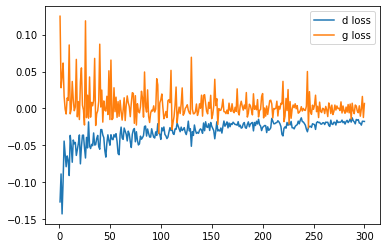

In [15]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

The Wassestein GANs, while easier to train and capable of better samples, need more cautious control on the training and will usually strongly benefit from additional layers in both the critic and generator.

More control on the initialization and the interleaved training is also needed.

These advanced practices will be discussed in an upcoming homework!

(5, 28, 28)


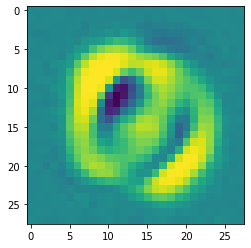

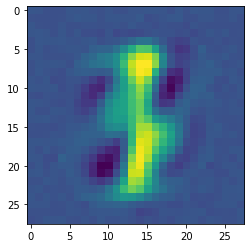

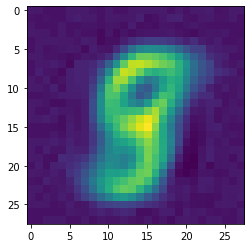

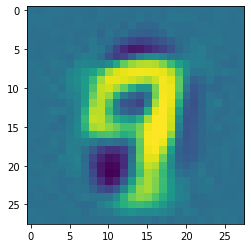

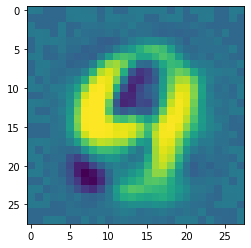

In [19]:
# Generate a fake sample for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[1])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[2])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[3])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[4])
plt.show()